In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
TRAIN_DIR = "mias_mini-train"
TEST_DIR = "mias_mini-test"
IM_WIDTH, IM_HEIGHT = 299, 299
FC_SIZE = 1024
batch_size = 75
NUM_CLASSES = 3
NUM_EPOCHS = 100

In [3]:
train_datagen = ImageDataGenerator(
                preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
  )

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
)

Found 4064 images belonging to 3 classes.
Found 1040 images belonging to 3 classes.


In [9]:
train_generator

In [4]:
import os
import numpy as np
import cv2


images = []
classes = ["0","1",'2']

for cat in classes:
    TRAIN_DIR = "mias_mini-train" + '/' + cat
    TEST_DIR = "mias_mini-test" +'/' + cat

    for imgName in os.listdir(TRAIN_DIR):
        if "png" in imgName:
            images.append(cv2.imread(TRAIN_DIR + '/' + imgName))

X_train = np.array(images[1:])  

In [5]:
X_train.shape

(4063, 256, 256, 3)

In [ ]:
%matplotlib inline
from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        self.img_rows = 256 
        self.img_cols = 256
        self.channels = 3

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        #noise_shape = (self.img_rows, self.img_cols, self.channels)
        #z = Input(shape=noise_shape)
        #z = Input((self.channels,self.img_rows, self.img_cols))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)
        #noise_shape = (self.channels, self.img_rows, self.img_cols)
        
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8)) 
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        
        images = []
        classes = ["0","1",'2']

        for cat in classes:
            TRAIN_DIR = "mias_mini-train" + '/' + cat
            TEST_DIR = "mias_mini-test" +'/' + cat

            for imgName in os.listdir(TRAIN_DIR):
                if "png" in imgName:
                    images.append(cv2.imread(TRAIN_DIR + '/' + imgName))

        X_train = np.array(images[1:])  

  


        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)
        
        print ("shape is", gen_imgs.shape)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        #fig.suptitle("DCGAN: Generated digits", fontsize=12)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("dcgan/images/mias_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 65, 65, 64)        0         
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 65, 65, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 65, 65, 64)        0         
__________

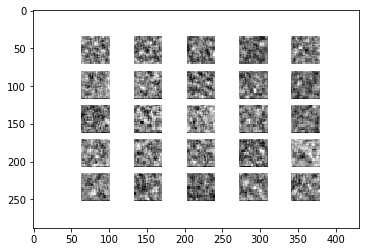

In [7]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('dcgan/images/mnist_0.png')

plt.imshow(img)
plt.show()

In [8]:
img.shape

(288, 432, 3)

In [14]:
%%writefile dcgan.py
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math


def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


def train(BATCH_SIZE):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    # X_train = X_train.reshape((X_train.shape, 1) + X_train.shape[1:])
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)


def generate(BATCH_SIZE, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(
        "dcgan/generated_image.png")


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", type=str)
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--nice", dest="nice", action="store_true")
    parser.set_defaults(nice=False)
    args = parser.parse_args()
    return args

if __name__ == "__main__":
    args = get_args()
    if args.mode == "train":
        train(BATCH_SIZE=args.batch_size)
    elif args.mode == "generate":
        generate(BATCH_SIZE=args.batch_size, nice=args.nice)

Writing dcgan.py


In [16]:
!python3.5 dcgan.py --mode generate --batch_size 128 --nice

Using TensorFlow backend.
dcgan.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1024, input_dim=100)`
  model.add(Dense(input_dim=100, output_dim=1024))
Traceback (most recent call last):
  File "dcgan.py", line 162, in <module>
    generate(BATCH_SIZE=args.batch_size, nice=args.nice)
  File "dcgan.py", line 121, in generate
    g.load_weights('generator')
  File "/usr/local/lib/python3.5/dist-packages/keras/models.py", line 707, in load_weights
    f = h5py.File(filepath, mode='r')
  File "/usr/local/lib/python3.5/dist-packages/h5py/_hl/files.py", line 269, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, swmr=swmr)
  File "/usr/local/lib/python3.5/dist-packages/h5py/_hl/files.py", line 99, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 78, in h5py.h5f.open
OSErr

In [2]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [105]:
import os
import numpy as np
import cv2

images = []
classes = ["1"]

for cat in classes:
    TRAIN_DIR = "mias_mini-train" + '/' + cat
    TEST_DIR = "mias_mini-test" +'/' + cat

    for imgName in os.listdir(TRAIN_DIR):
        if "png" in imgName:
            images.append(cv2.imread(TRAIN_DIR + '/' + imgName))

X_train = np.array(images[1:])  

In [106]:
X_train.shape

(86, 256, 256, 3)

In [17]:
generator = Sequential([
        Dense(64*64*64, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),
        Reshape((64,64,64)),
        UpSampling2D(),
        Conv2D(32, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(3, (5, 5), padding='same'),
        Activation('tanh'),
    ])

In [18]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 262144)            26476544  
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 262144)            0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 262144)            1048576   
_________________________________________________________________
reshape_9 (Reshape)          (None, 64, 64, 64)        0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 32)      51232     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 128, 128, 32)      0         
__________

In [26]:
discriminator = Sequential([
        Conv2D(32, (5, 5), strides=(2,2), input_shape=(256,256,3), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Conv2D(64, (5, 5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

In [27]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
__________

In [28]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [29]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [30]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 256, 256, 3)       27578883  
_________________________________________________________________
sequential_11 (Sequential)   (None, 1)                 315841    
Total params: 27,894,724
Trainable params: 27,054,531
Non-trainable params: 840,193
_________________________________________________________________


In [31]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [32]:
train(30, 128)


  0%|          | 0/31 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 31/31 [01:29<00:00,  2.89s/it]


In [33]:
generator.save_weights('gen_30_scaled_images.h5')
discriminator.save_weights('dis_30_scaled_images.h5')

In [34]:
train(20, 128)

100%|██████████| 31/31 [01:29<00:00,  2.89s/it]


In [35]:
generator.save_weights('gen_50_scaled_images.h5')
discriminator.save_weights('dis_50_scaled_images.h5')

In [36]:
generator.load_weights('gen_50_scaled_images.h5')
discriminator.load_weights('dis_50_scaled_images.h5')

In [37]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

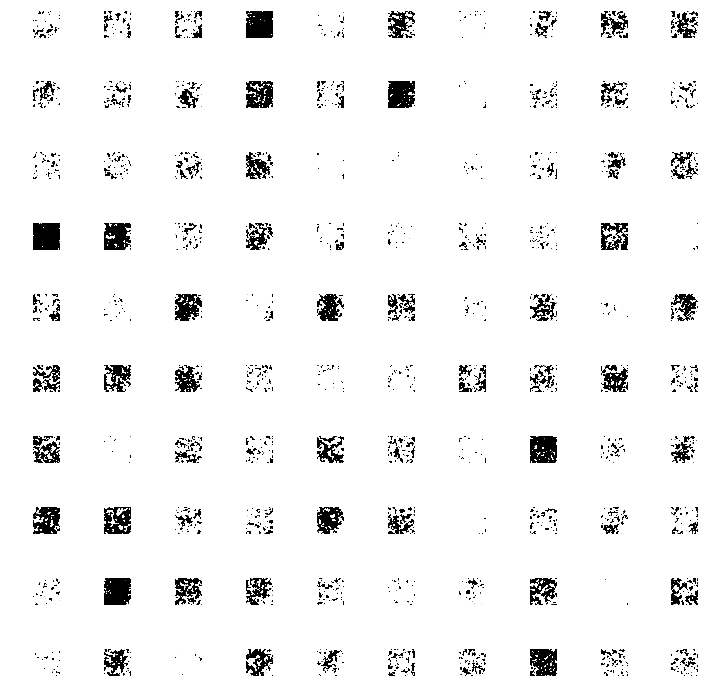

In [38]:

plot_output()

## Try with ReLu

In [387]:
generator = Sequential([
        Dense(128*8*8, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),
        Reshape((8,8,128)),
        UpSampling2D(),
        Conv2D(64, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(32, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(16, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(8, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(1, (5, 5), padding='same'),
        Activation('tanh'),
    ])

In [388]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 8192)              32768     
_________________________________________________________________
reshape_25 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_69 (UpSampling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 64)        204864    
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 16, 16, 64)        0         
__________

In [389]:
discriminator = Sequential([
        Conv2D(32, (5, 5), strides=(2,2), input_shape=(256,256,1), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Conv2D(64, (5, 5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

In [390]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 128, 128, 32)      832       
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 64, 64, 64)        51264     
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 262144)            0         
__________

In [391]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [392]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [393]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_47 (Sequential)   (None, 256, 256, 1)       1132961   
_________________________________________________________________
sequential_48 (Sequential)   (None, 1)                 314241    
Total params: 1,447,202
Trainable params: 1,116,337
Non-trainable params: 330,865
_________________________________________________________________


In [394]:
X_train = X_train.reshape(86,256,256,1)

In [395]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [403]:
train(30, 20)

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


In [404]:
generator.save_weights('gen1_30_scaled_images.h5')
discriminator.save_weights('dis1_30_scaled_images.h5')

In [405]:
train(30, 20)

100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


In [406]:
generator.save_weights('gen1_50_scaled_images.h5')
discriminator.save_weights('dis1_50_scaled_images.h5')

In [407]:
generator.load_weights('gen1_50_scaled_images.h5')
discriminator.load_weights('dis1_50_scaled_images.h5')

In [408]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(40,40))
    for i in range(preds.shape[0]):
        plt.subplot(20, 5, i+1)
        plt.imshow(preds[i, :, :,:].reshape(256,256), cmap ='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

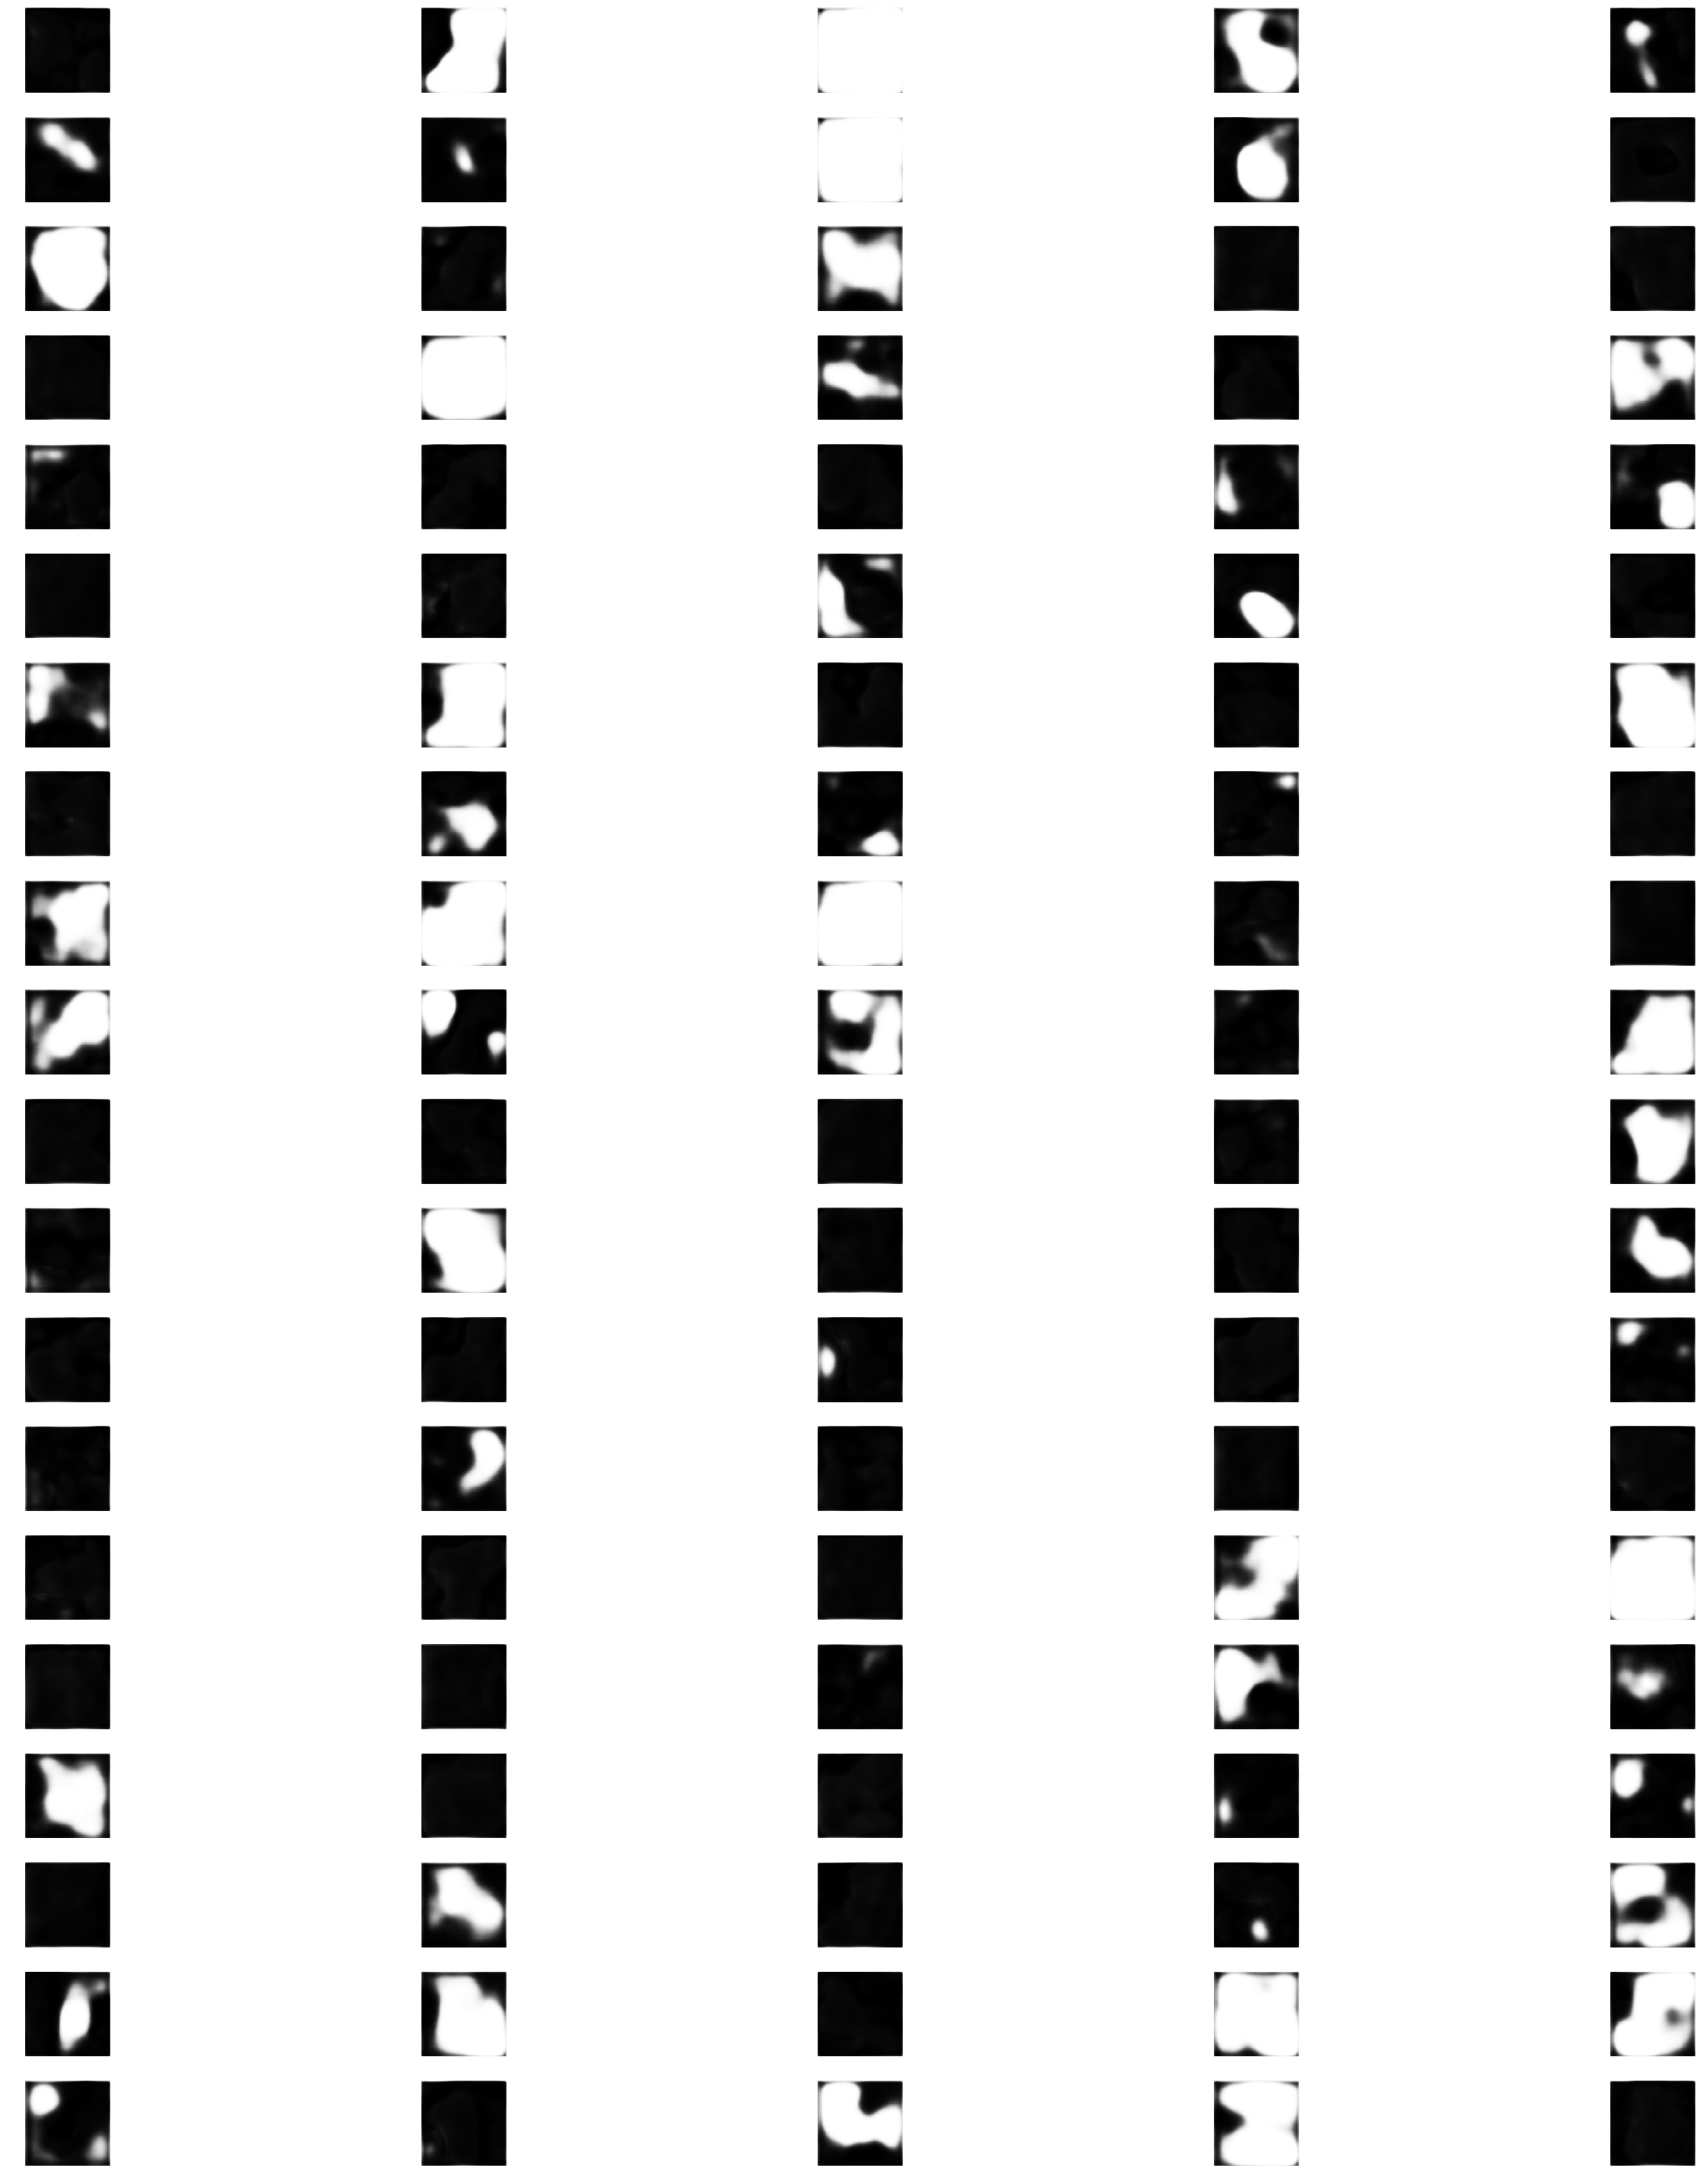

In [409]:

plot_output()

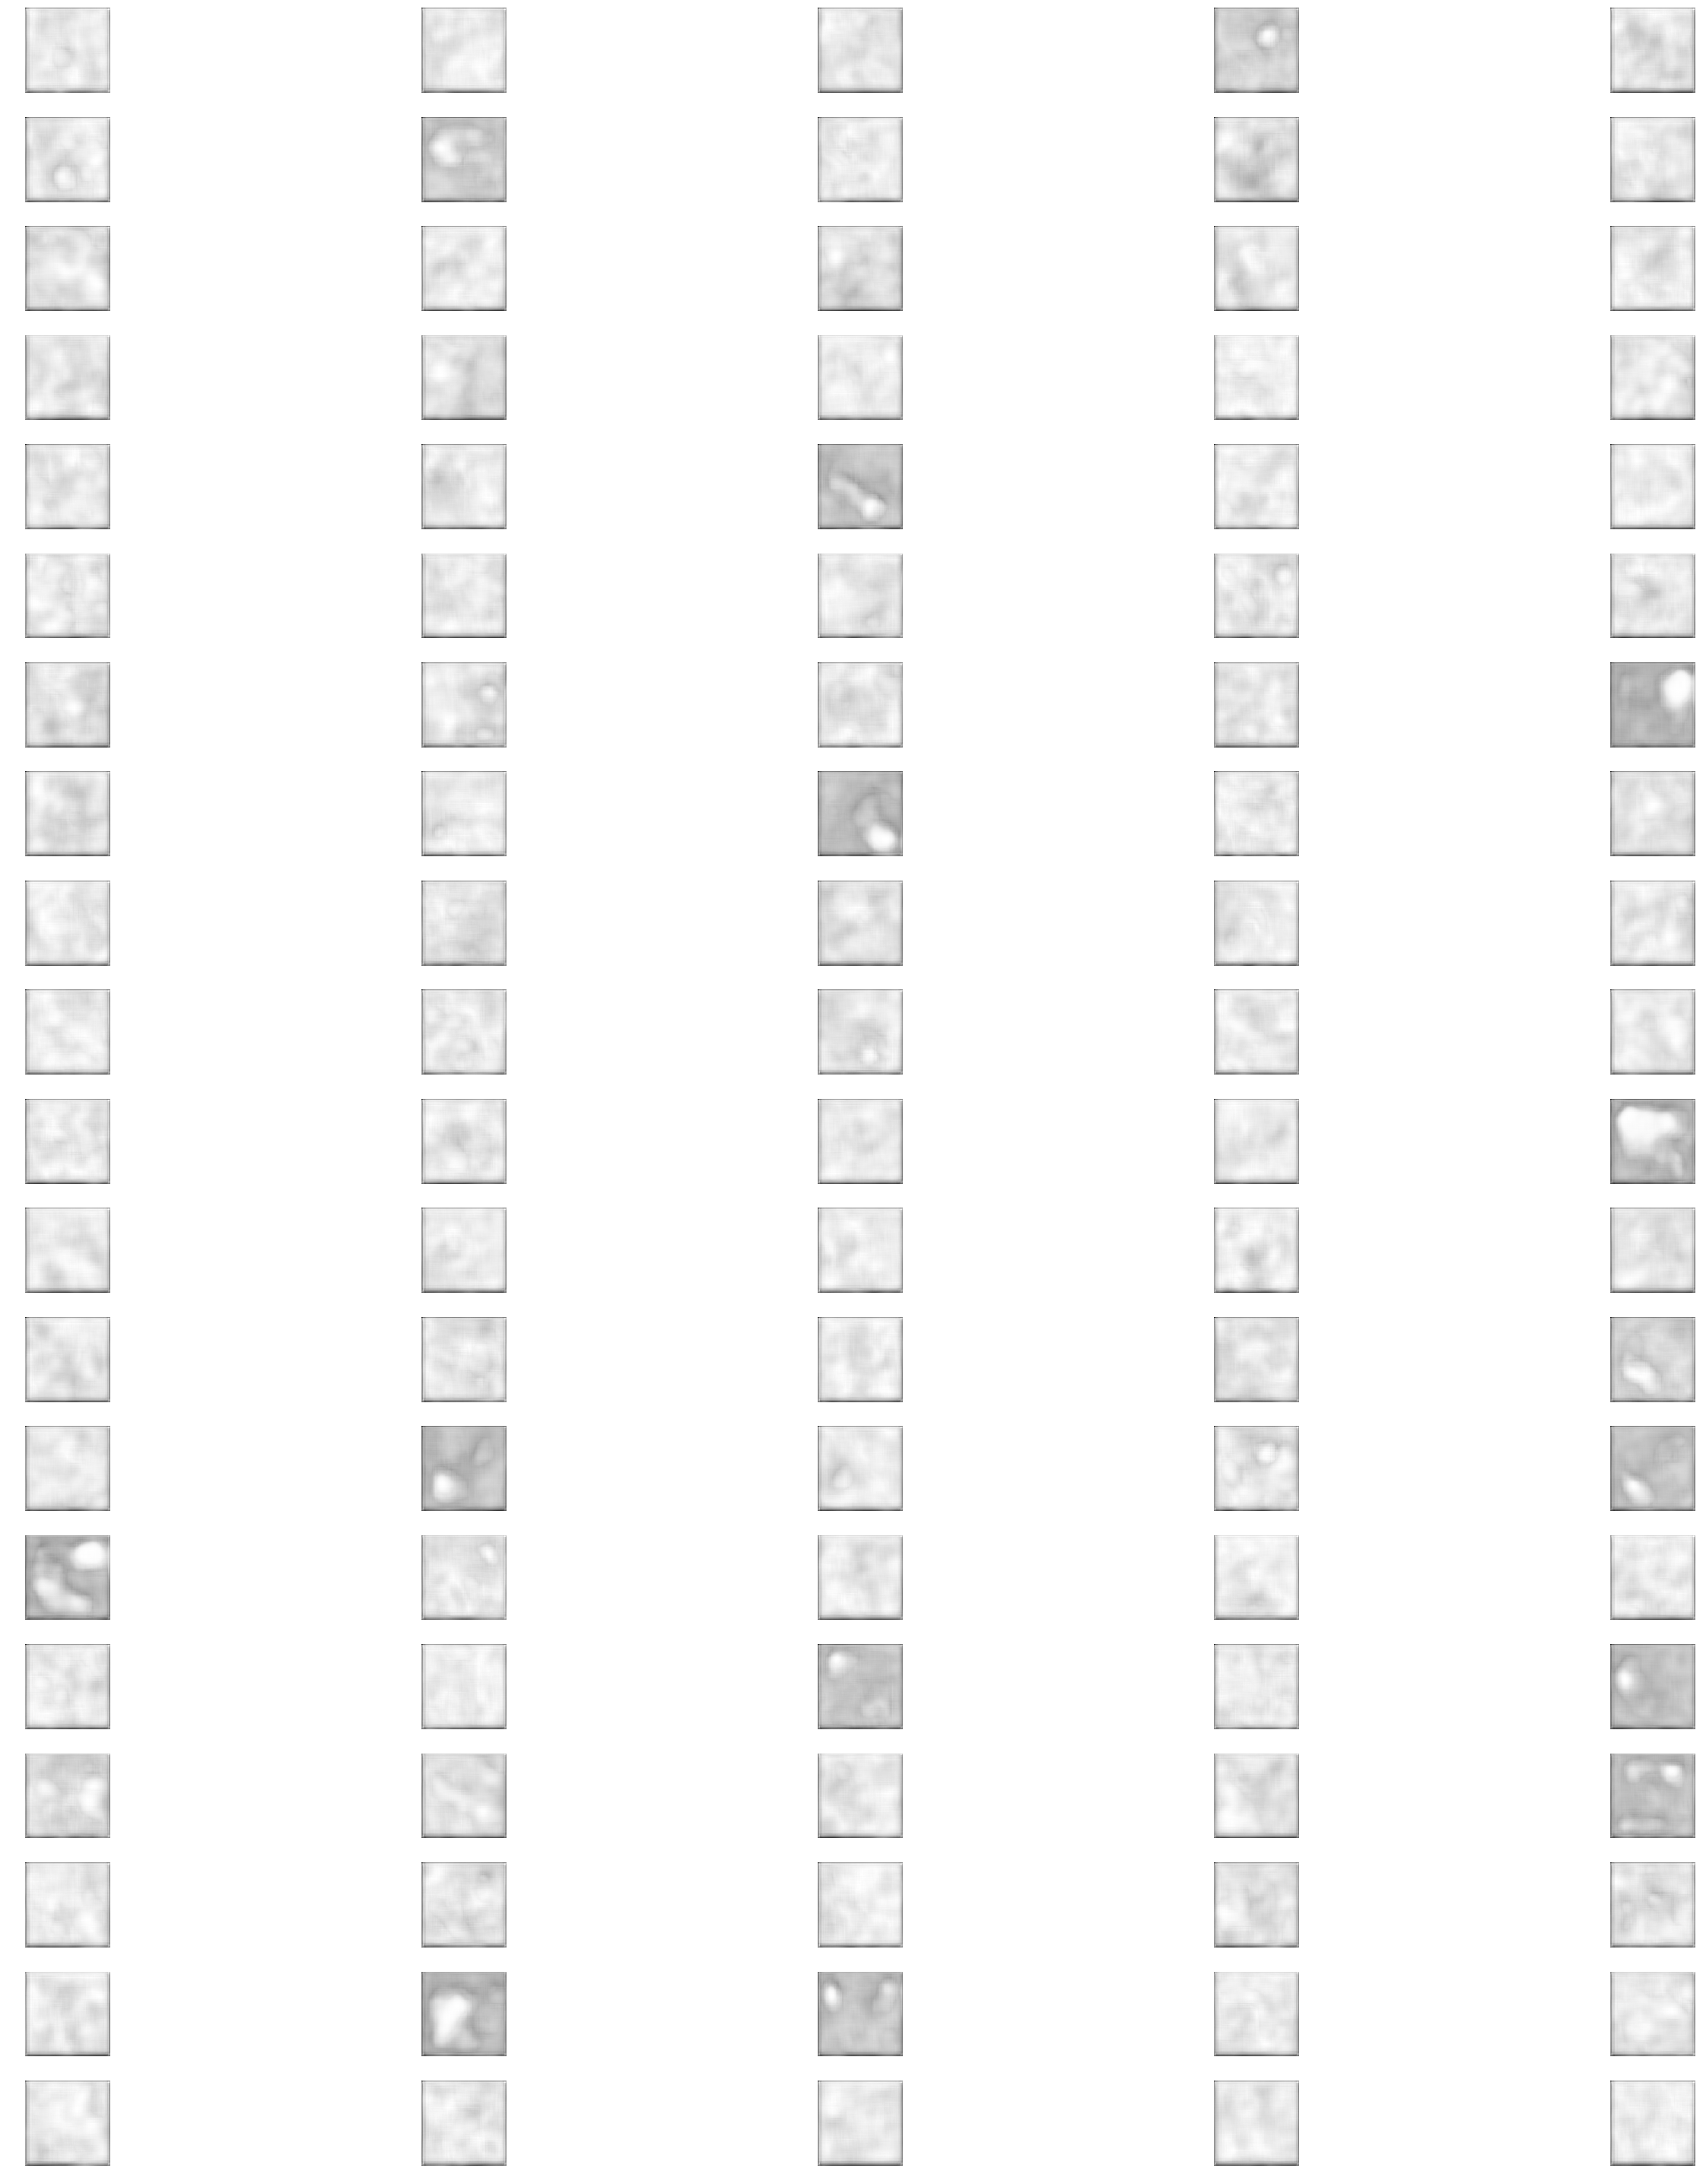

In [254]:

plot_output()

In [175]:
X_train.shape

(86, 256, 256, 1)

In [176]:
def plot_input():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(40,40))
    for i in range(X_train.shape[0]):
        plt.subplot(20, 5, i+1)
        plt.imshow(X_train[i, :, :,:].reshape(256,256), cmap ='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

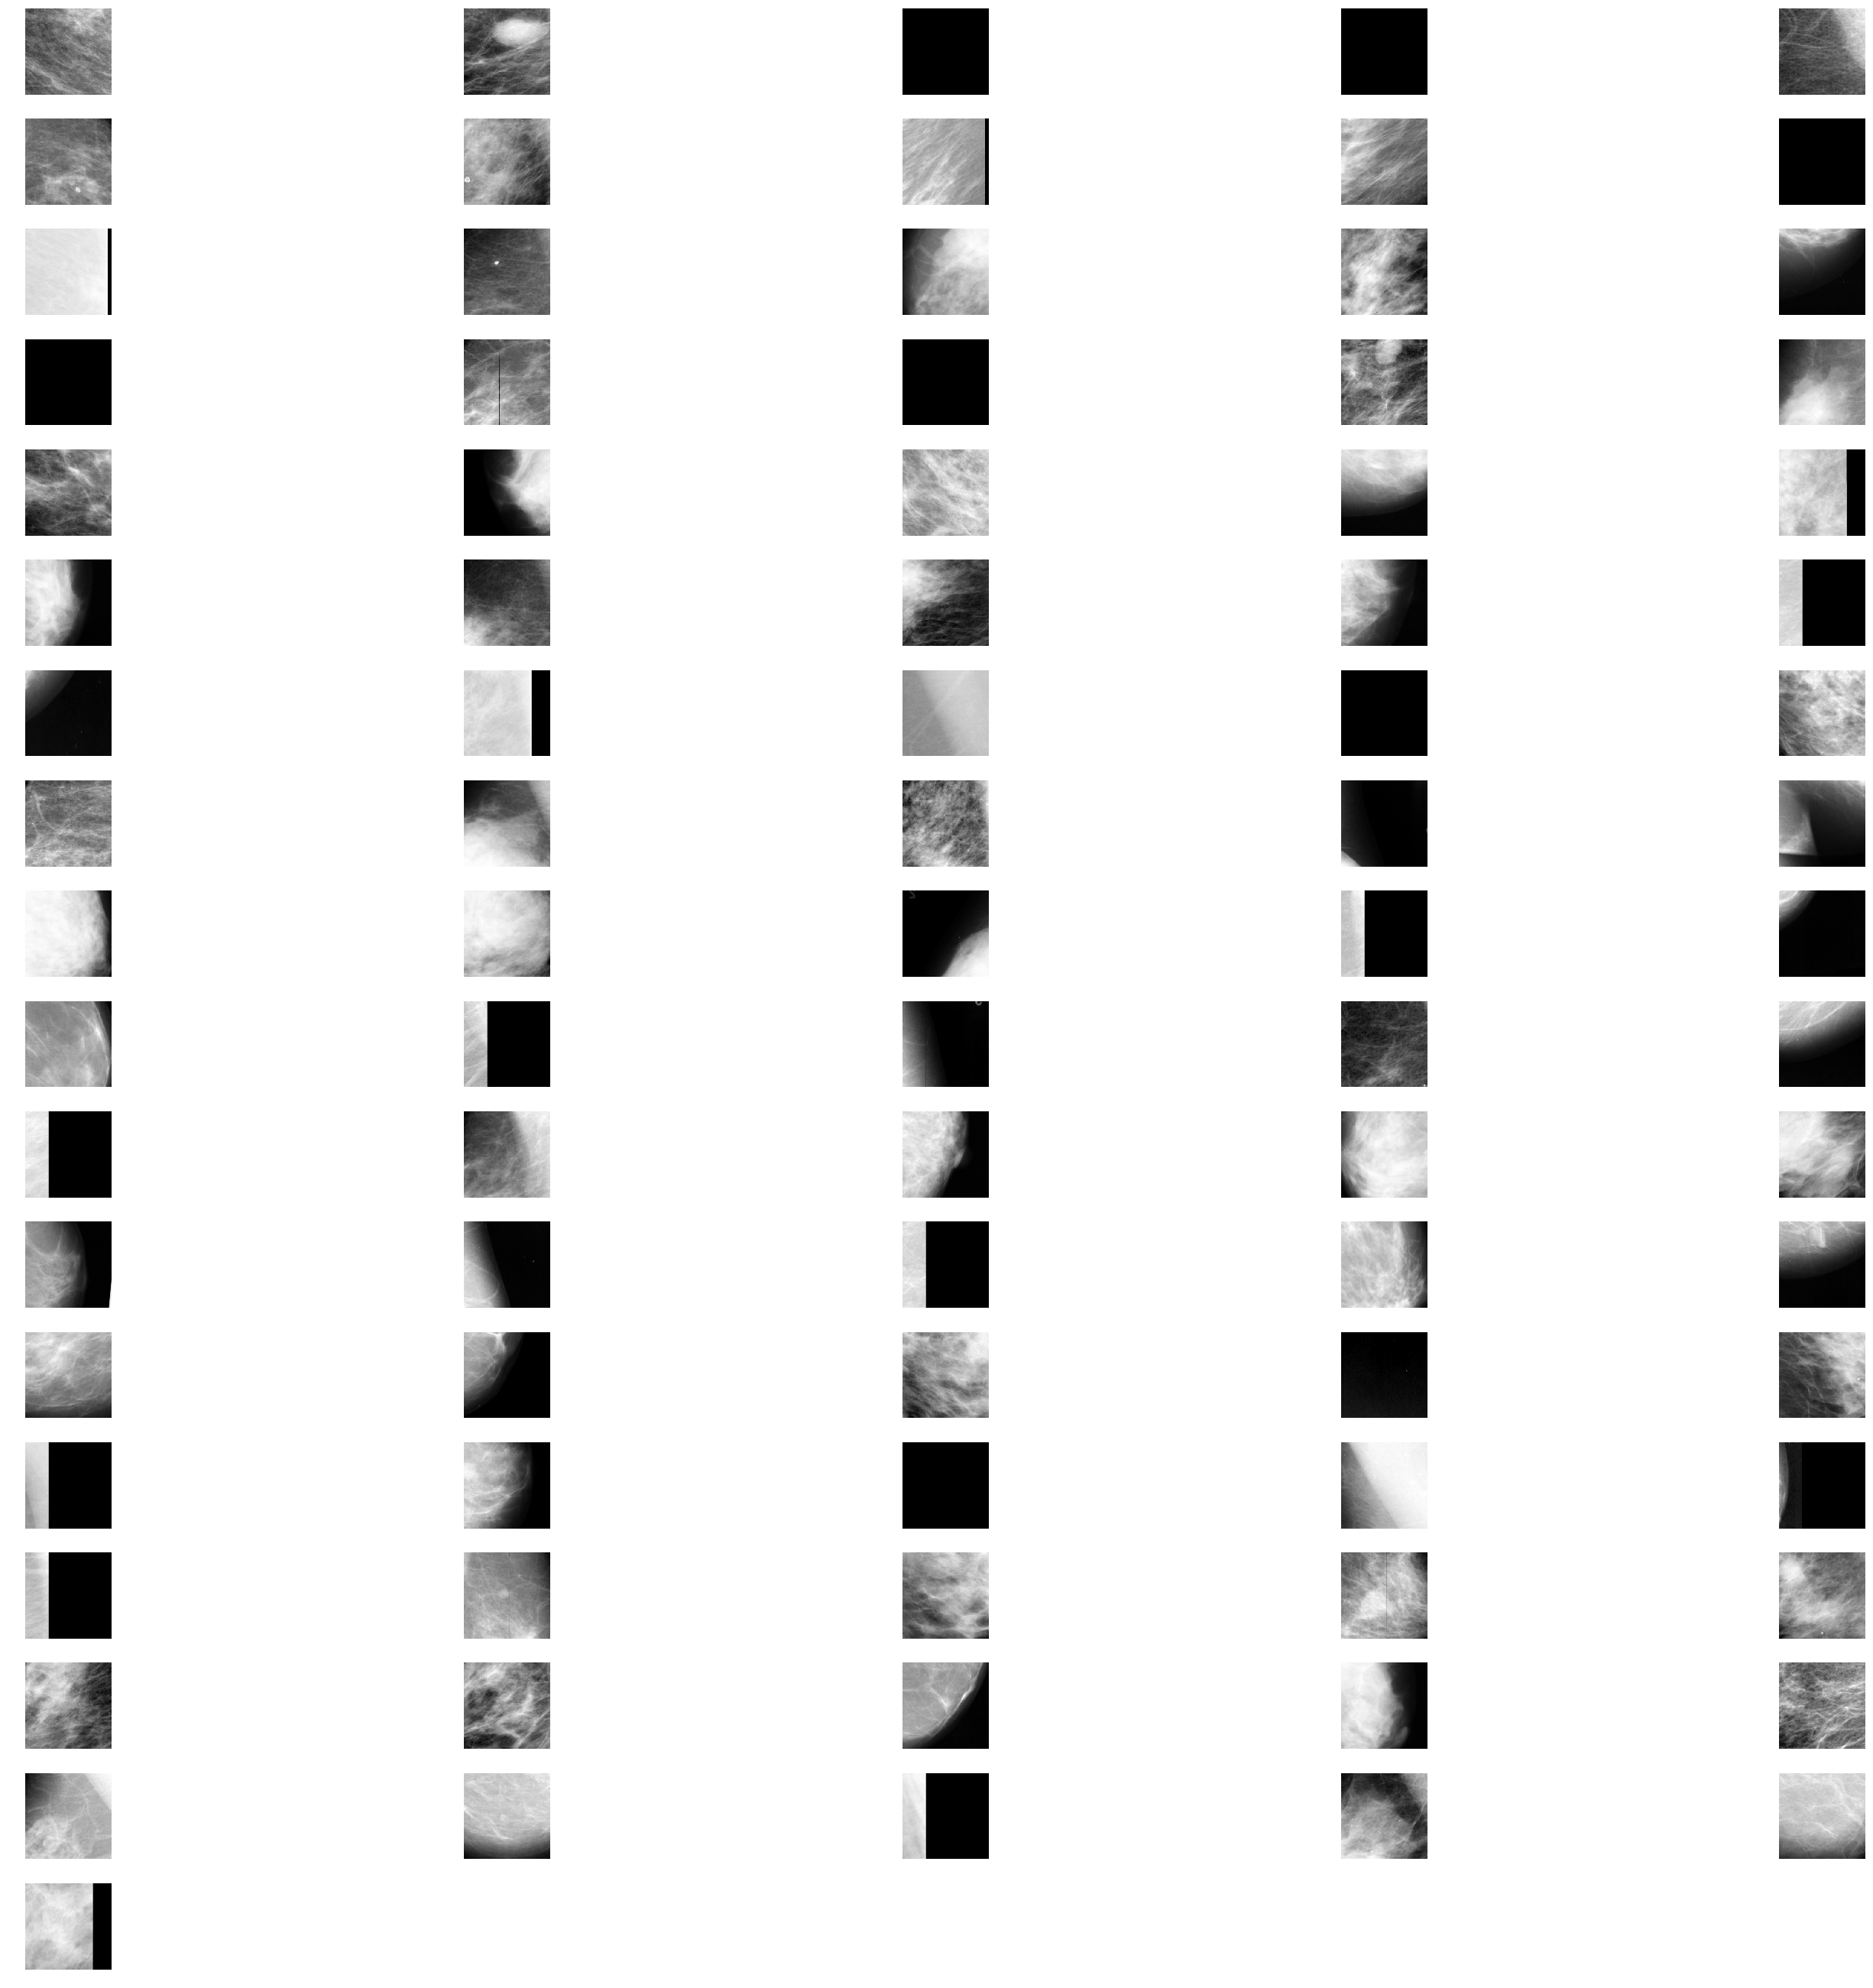

In [177]:

plot_input()

In [146]:
try_input = np.random.rand(100, 100)
preds = generator.predict(try_input)

In [147]:
preds[0].shape

(256, 256, 1)

In [73]:
np.min(preds[0,:,:,1])

-1.0

In [151]:
img = preds[0].reshape(256,256)

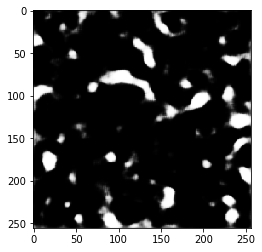

In [152]:
plt.imshow(img, cmap ='gray')